# Feature selection (simple)

Download the fruits data [here](https://drive.google.com/file/d/1M8tiAWDZclABJN1Meq9oEHCLJTNyHdpP/view?usp=share_link)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
data = pd.read_csv("/content/fruits_data_ext.csv")
print(data.columns)

Index(['Unnamed: 0', 'fruit_label', 'fruit_name', 'fruit_subtype', 'mass',
       'width', 'height', 'color_score'],
      dtype='object')


In [3]:
# Load dataset
X, y = np.array([data['width'], data['height']]).T, np.array(data["fruit_label"])
print (X.shape, y.shape)

(177, 2) (177,)


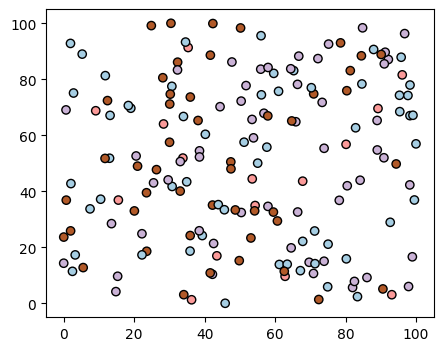

In [48]:
_, ax = plt.subplots(figsize=(5,4))
ax.scatter(X[:,0]*100, X[:,1]*100, c=y, cmap='Paired', edgecolors='k')

In [4]:
np.random.seed(1)

## Add some noisy data to degrade features
random_columns = np.random.permutation(22)
random_features = np.random.RandomState(1000).uniform(0, 0.5, size=(X.shape[0], 20))
X = np.hstack((X, random_features))
X = X[:, random_columns]

print (random_columns)
print (X.shape, y.shape)

[19 16  3 13 18 15 10  4  2 17  6  7  1 14  0 21 20  9  8 12 11  5]
(177, 22) (177,)


In [5]:
# Normalize data to 0-1
X = MinMaxScaler().fit_transform(X)

# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print ("\n", random_columns, "\n", np.arange(22))

(132, 22) (45, 22) (132,) (45,)

 [19 16  3 13 18 15 10  4  2 17  6  7  1 14  0 21 20  9  8 12 11  5] 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


## Classification using SVC

In [6]:
# Train a classifier using SVC on train data
svm = SVC(kernel='linear')

svm.fit(X_train, y_train)

SVC(kernel='linear')

Acc= 0.6444


<Axes: >

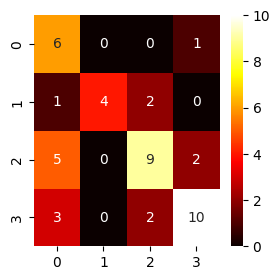

In [7]:
# Take predictions and compute some metrics (acc and CM)
predictions = svm.predict(X_test)
acc = accuracy_score(y_test, predictions)
cm  = confusion_matrix(y_test, predictions)

print ("Acc= {0:.4f}".format(acc))
_, ax = plt.subplots(figsize=(3,3))
sns.heatmap(cm, cmap='hot', annot=True, ax = ax)

## Use Recursive Feature Elimination

### RFE -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)


In [ ]:
from sklearn.feature_selection import RFE

# Create a new SVC classifier
clf = SVC(kernel='linear')

# Compute RFE
rfe = RFE( estimator = clf , n_features_to_select = 2 )

best_features = rfe.fit( X_train , y_train )

In [ ]:
# See results
print("Num Features: %d" % best_features.n_features_)
print("Selected Features: %s" % best_features.ranking_)
print("                 : %s" % np.arange(22))

Num Features: 2
Selected Features: [ 4 19 12 15  3 10 20 18 17  9 11  5  1 13  1 16  8  2 21  7  6 14]
                 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [ ]:
list_best = np.where(best_features.ranking_ == 1)[0].tolist()
print (list_best)

[12, 14]


In [ ]:
# Select best features
best_train = X_train[:, list_best]
best_test  = X_test[:, list_best]

print(best_train.shape, best_test.shape)

(132, 2) (45, 2)


In [ ]:
# Retrain classifier on best features and make predictions
svm_rfe = SVC(kernel='linear')

svm_rfe.fit(best_train, y_train)

SVC(kernel='linear')

For Recursive feature elimination
Acc before: 0.644, Acc Now: 0.622


<Axes: >

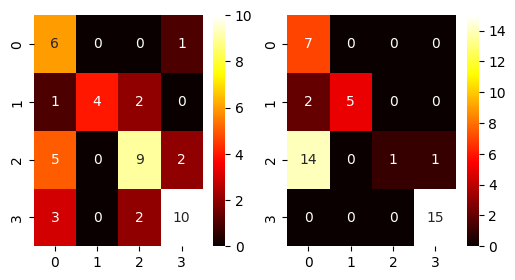

In [ ]:
predictions = svm_rfe.predict(best_test)

# Compute metrics
acc_best = accuracy_score(y_test, predictions)
cm_best  = confusion_matrix(y_test, predictions)

print("For Recursive feature elimination")
print ("Acc before: {0:.3f}, Acc Now: {1:.3f}".format(acc, acc_best))
_, axes = plt.subplots(1,2, figsize=(6,3))
sns.heatmap(cm, annot=True, cmap='hot', ax=axes[0])
sns.heatmap(cm_best, annot=True, cmap='hot', ax=axes[1])

## Use univariate selection to determine best features


### SelectKBest -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)

Metrics: [F_classif (ANOVA)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif), [Chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2), [mutual_information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)

In [27]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif #ANOVA

skb = SelectKBest( mutual_info_classif , k = 2 )
skb.fit( X_train , y_train )

SelectKBest(k=2, score_func=<function mutual_info_classif at 0x7b9735079480>)

In [28]:
best_train = skb.fit_transform(X_train, y_train)
best_test = skb.fit_transform(X_test, y_test)

print (best_train.shape, best_test.shape)

(132, 2) (45, 2)


In [29]:
print("Num Features: %d" % best_train.shape[0])
print("Selected Features: %s" % np.array(skb.get_support(),dtype=int).tolist())
print("                 : %s" % np.arange(22))

Num Features: 132
Selected Features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
                 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [30]:
# Retrain classifier on best features and make predictions
svm_best = SVC(kernel='linear')

svm_best.fit (best_train, y_train)

SVC(kernel='linear')

For SelectKBest
Acc before: 0.6444, Acc Now: 0.6222


<Axes: >

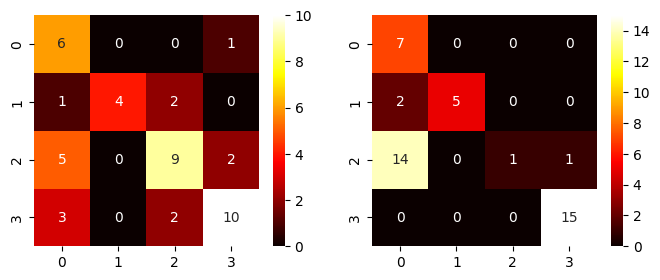

In [31]:
# Make some predictions
predictions = svm_best.predict(best_test)

# Compute metrics
acc_best = accuracy_score(y_test, predictions)
cm_best  = confusion_matrix(y_test, predictions)

print("For SelectKBest")
print ("Acc before: {0:.4f}, Acc Now: {1:.4f}".format(acc, acc_best))
_, axes = plt.subplots(1,2, figsize=(8,3))
sns.heatmap(cm, annot=True, cmap='hot', ax=axes[0])
sns.heatmap(cm_best, annot=True, cmap='hot', ax=axes[1])

### SelectPercentile -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile)

In [42]:
from sklearn.feature_selection import SelectPercentile, f_classif, chi2, mutual_info_classif #ANOVA

spc = SelectPercentile( f_classif , percentile = 5)
spc.fit( X_train , y_train )

SelectPercentile(percentile=5)

In [43]:
best_train = spc.fit_transform(X_train, y_train)
best_test = spc.fit_transform(X_test, y_test)

print (best_train.shape, best_test.shape)

(132, 2) (45, 2)


In [44]:
print("Num Features: %d" % best_train.shape[0])
print("Selected Features: %s" % np.array(spc.get_support(), dtype='uint8').tolist() )
print("                 : %s" % np.arange(22))

Num Features: 132
Selected Features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
                 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [45]:
# Retrain classifier on best features and make predictions
svm_best = SVC(kernel='linear')

svm_best.fit(best_train, y_train)

SVC(kernel='linear')

For SelectPercentile
Acc before: 0.6444, Acc Now:0.6222


<Axes: >

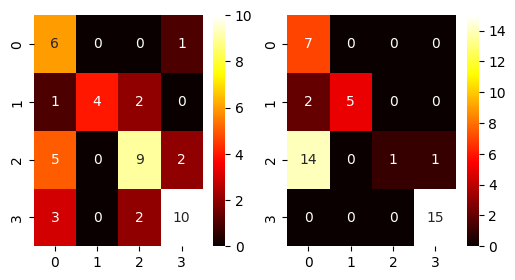

In [46]:
predictions = svm_best.predict(best_test)

# Compute metrics
acc_best = accuracy_score(y_test, predictions)
cm_best  = confusion_matrix(y_test, predictions)

print("For SelectPercentile")
print ("Acc before: {0:.4f}, Acc Now:{1:.4f}".format(acc, acc_best))
_, axes = plt.subplots(1,2,figsize=(6,3))
sns.heatmap(cm, annot=True, cmap='hot', ax=axes[0])
sns.heatmap(cm_best, annot=True, cmap='hot', ax=axes[1])

## Use Metatransformer to determine best features

### SelectFromModel -> [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)

In [76]:
from sklearn.feature_selection import SelectFromModel

# Create a new SVC classifier
clf = SVC(kernel='linear')

# Compute metatransformer
sfm = SelectFromModel(estimator = clf, threshold=1, max_features=2)

best_features = sfm.fit(X_train, y_train)

In [77]:
# Transform best features
best_train = sfm.transform(X_train)
best_test  = sfm.transform(X_test)

print(best_train.shape, best_test.shape)

(132, 2) (45, 2)


In [78]:
print("Num Features: %d" % sfm.n_features_in_)
print("Selected Features: %s" % np.array(sfm.get_support(), dtype=int).tolist() )
print("                 : %s" % np.arange(22))

Num Features: 22
Selected Features: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
                 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [79]:
# Retrain classifier on best features and make predictions
svm_best = SVC(kernel='linear')

svm_best.fit(best_train, y_train)

SVC(kernel='linear')

For SelectFromModel
Acc before: 0.6444, Acc Now: 0.6222


<Axes: >

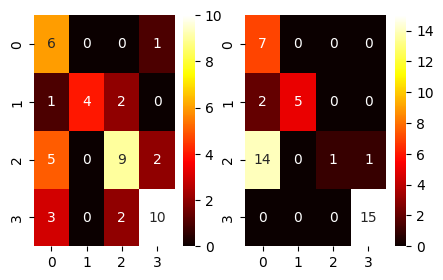

In [80]:
predictions = svm_best.predict(best_test)

# Compute metrics
acc_best = accuracy_score(y_test, predictions)
cm_best  = confusion_matrix(y_test, predictions)

print("For SelectFromModel")
print("Acc before: {0:.4f}, Acc Now: {1:.4f}".format(acc, acc_best))
_, axes = plt.subplots(1,2,figsize=(5,3))
sns.heatmap(cm, annot=True, cmap='hot', ax=axes[0])
sns.heatmap(cm_best, annot=True, cmap='hot', ax=axes[1])